In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

# Installing PySpark Locally

Comment out the following lines to install Spark locally in the same folder as this notebook:

In [2]:
# !curl -O https://d3kbcqa49mib13.cloudfront.net/spark-2.2.0-bin-hadoop2.7.tgz
# !tar -xvf spark-2.2.0-bin-hadoop2.7.tgz

The following Python Library will configure your python environment

In [3]:
# !pip install findspark

If you would like to try using Spark on a cluster for free without any setup checkout [Databricks Community Edition](https://databricks.com/try-databricks)

# Launching PySpark

Setup the PySpark environment.

In [4]:
import os
import findspark
os.environ["PYSPARK_PYTHON"] = "python3"
findspark.init("spark-2.2.0-bin-hadoop2.7",)

Import a few common components of Spark SQL

In [5]:
from pyspark.sql import SparkSession, Column, Row, functions as F 

Initialize the SparkSQL session which contains a basic Spark Context.  This may take a few moments to launch the cluster of (typically 4 to 8 python jobs in the background).  Note in a real Spark deployment you would simply change the `.master("local[*]")` to instead point to the YARN resource manager.  To learn more about deploying Spark on a cluster of machines read [this tutorial](https://spark.apache.org/docs/latest/cluster-overview.html).

In [6]:
spark = (
    SparkSession.builder
        .master("local[*]")
        .appName("LectureExample")
        .getOrCreate()
)
sc = spark.sparkContext

# Running Basic Spark Commands

## RDDs and Dataframes

Spark exposes two interfaces to data:

1. An [RDD](http://spark.apache.org/docs/2.1.0/api/python/pyspark.html#pyspark.RDD) interface which represents a collection of rows which can be any python object.
1. A [dataframe](http://spark.apache.org/docs/2.1.0/api/python/pyspark.sql.html) interface which is similar to Pandas (but with less functionality) and built on top of the RDD interface

Today Spark users are encouraged to try to use the dataframe interface which provides additional system performance optimizations. However, in the homework and in this notebook we will use a bit of both to get some exposure the the low-level side of distributed data processing.




### The following creates an RDD with 32 numbers 

The `sc` variable contains the SparkContext initialized above and it is used to created new RDDs.  In this example we use python to create 32 numbers locally and then `sc.parallelize` to distribute those 32 numbers to our cluster of machines.  Each machine gets a subset of the numbers.  If we had more than 32 machines then some will not be given a number.

In [7]:
numbers = sc.parallelize(range(32))

### Basic operations on RDDs

There are a wide range of basic operations on RDDs.  Each of these operations runs across all the workers and results in either a value or another RDD.

In [8]:
numbers.sum()

496

In [9]:
numbers.count()

32

In [10]:
print(numbers.take(2))

[0, 1]


In [11]:
print(numbers.collect())

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]


In [12]:
numbers.filter(lambda x: x % 2 == 0)

PythonRDD[5] at RDD at PythonRDD.scala:48

In [13]:
numbers.filter(lambda x: x % 2 == 0).count()

16

In [14]:
( # What does this do?
    numbers
     .map(lambda x: x + 1)
     .filter(lambda x: x % 2 == 0)
     .map(lambda x: str(x) + " is even.")
     .collect()
)

['2 is even.',
 '4 is even.',
 '6 is even.',
 '8 is even.',
 '10 is even.',
 '12 is even.',
 '14 is even.',
 '16 is even.',
 '18 is even.',
 '20 is even.',
 '22 is even.',
 '24 is even.',
 '26 is even.',
 '28 is even.',
 '30 is even.',
 '32 is even.']

The above operations resulted in jobs being executed on a local Spark workers (separate python instances).  We can learn more about the Spark configuration here.  Click on the SparkUI link to view your local cluster.

In [15]:
spark

Are these really running on remote processes:

In [16]:
os.getpid()

40528

In [17]:
import os
numbers.map(lambda x: os.getpid()).distinct().collect()

[40592, 40593, 40594, 40587, 40588, 40589, 40590, 40591]

## Parallelism and Spark

Let's use Spark to parallelize a simulation.

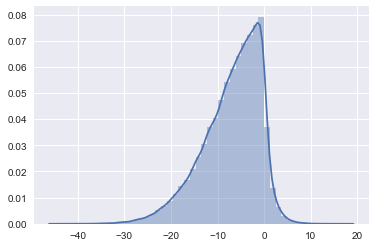

In [18]:
import numpy as np
import seaborn as sns
np.random.seed(42)

weird_data = np.random.randn(100000)**2 - 10 *np.abs( np.random.randn(100000) )
sns.distplot(weird_data)

In [19]:
def resample(data, seed):
    import numpy as np
    np.random.seed(seed)
    return data[np.random.randint(0, len(data),len(data))]

def boot_strap_mean(data, seed):
    return resample(data, seed).mean()

In [20]:
boot_strap_mean(weird_data, 43)

-6.9569884501827

In [21]:
seeds = np.arange(10000) + 42
samples = (
    sc.parallelize(seeds)
        .map(lambda seed: boot_strap_mean(weird_data, seed))
)

In [22]:
samples.count()

10000

In [23]:
samples.mean()

-6.9683648586907205

In [24]:
samples.mean()

-6.9683648586907205

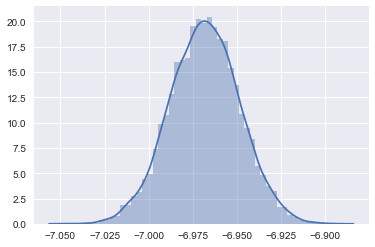

In [25]:
sns.distplot(samples.collect())

## Caching in Spark

One of the key innovations in Spark is the ability to cache computation. 

In [26]:
%%timeit

samples.mean()

1 loop, best of 3: 4.16 s per loop


In [27]:
samples.persist()

PythonRDD[17] at collect at <ipython-input-25-e4ba16f0acfd>:1

This time when we run it the result will get saved

In [28]:
samples.mean()

-6.9683648586907205

If we run it again things will be much faster

In [29]:
samples.mean()

-6.9683648586907205

Timing after warming the cache:

In [30]:
%%timeit 
samples.mean()

10 loops, best of 3: 148 ms per loop


**Orders of magnitude faster** ... not surprising.  How long did this take if I just use basic Python

### Comparing to Local Execution

In [31]:
%%timeit 
samples_local = np.array([
    boot_strap_mean(weird_data, seed)
for seed in seeds])

1 loop, best of 3: 10.7 s per loop


# Parsing Text

Here we will work through the standard process of preparing a text dataset.  Note that while we will be loading from the local filesystem here. In a distributed computing environment the arguments to the text file command would be very similar (see below).

Uncomment the following lines to download some text data to process.

In [33]:
# !curl -O https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip
# !unzip smsspamcollection.zip

The following line will load the text file into an RDD.  If this file were running in a distributed filesystem the path would have been:
```python
raw_lines = sc.textFile("hdfs://silly_data/SMSSPamCollection")
```

In [34]:
raw_lines = sc.textFile("./SMSSpamCollection")

We can get a look at a few lines:


In [35]:
raw_lines.take(3)

['ham\tGo until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...',
 'ham\tOk lar... Joking wif u oni...',
 "spam\tFree entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's"]

In the following RDD code we can transform the data file into records:

In [36]:
records = (
    raw_lines
        .map(lambda x: x.lower()) # Make it lower case
        .map(lambda x: x.split("\t")) # Split records
        .map(lambda x: Row(label=x[0], text=x[1])) # Make Row objects (from SparkSQL)
)

In [37]:
records.take(3)

[Row(label='ham', text='go until jurong point, crazy.. available only in bugis n great world la e buffet... cine there got amore wat...'),
 Row(label='ham', text='ok lar... joking wif u oni...'),
 Row(label='spam', text="free entry in 2 a wkly comp to win fa cup final tkts 21st may 2005. text fa to 87121 to receive entry question(std txt rate)t&c's apply 08452810075over18's")]

How many Spam

In [38]:
records.filter(lambda x: x['label'] == 'spam').count()

747

How many Ham

In [39]:
records.filter(lambda x: x['label'] == 'ham').count()

4827

## Computing Word Counts

If we wanted to determine if a post is spam we might first check to see if it has words that occur more often in spam messages. Before we proceed we need to introduce another (odd) Spark function.

In [40]:
sc.range(1,5).collect()

[1, 2, 3, 4]

In [41]:
sc.range(1,5).map(lambda x: [i for i in range(x) ]).collect()

[[0], [0, 1], [0, 1, 2], [0, 1, 2, 3]]

In [42]:
sc.range(1,5).flatMap(lambda x: [i for i in range(x) ]).collect()

[0, 0, 1, 0, 1, 2, 0, 1, 2, 3]

Let's count how often word occur in general:

In [43]:
word_counts = (
    records
        .map(lambda x: x['text'])     # extract the text
        .flatMap(lambda x: x.split()) # split on whitespace and
                                      # convert each word into a separate record.
        .filter(lambda x: len(x) > 2) # keep words that have 3 or more letters
        .map(lambda x: (x, 1))           # Count each word 
        .reduceByKey(lambda a, b: a + b) # Sum the counts
)

In [44]:
word_counts.map(lambda x: (x[1], x[0])).top(10)

[(1921, 'you'),
 (1328, 'the'),
 (968, 'and'),
 (703, 'for'),
 (677, 'your'),
 (571, 'have'),
 (559, 'call'),
 (486, 'are'),
 (470, 'that'),
 (422, 'but')]

## Word Counts by Label

In [45]:
word_counts_by_label = (
    records
        .flatMap(lambda x: ((x['label'], w) for w in x['text'].split()))    
        .filter(lambda x: len(x[1]) > 2) # keep words that have 3 or more letters
        .map(lambda x:  # Count each word 
             (x[1], np.array([1.0, 0.0]) if x[0] == 'spam' else np.array([0.0, 1.0])  ))          
        .reduceByKey(lambda a, b: a + b) # Sum the counts
)

In [46]:
word_counts_by_label.take(3)

[('until', array([  5.,  22.])),
 ('jurong', array([ 0.,  1.])),
 ('crazy..', array([ 0.,  1.]))]

Computing the words with highest count in Spam relative to Ham:

In [47]:
spam_ratio = (
    word_counts_by_label.
        map(lambda x: (x[0], (x[1][0] + 1.0) / (x[1][1] + 1.0)))
)    

In [48]:
spam_ratio.take(2)

[('until', 0.2608695652173913), ('jurong', 0.5)]

Taking the top spam ratio words we get:

In [49]:
spam_ratio.map(lambda x: (x[1], x[0])).top(10)

[(107.0, 'claim'),
 (65.0, 'won'),
 (59.0, 'prize'),
 (43.0, 'urgent!'),
 (41.0, 'tone'),
 (39.0, 'awarded'),
 (34.0, '£1000'),
 (31.0, '150ppm'),
 (30.0, 'guaranteed'),
 (27.0, 'entry')]

# Spark DataFrames and SQL

Today people are encourage to use the SparkSQL and Dataframe interfaces for basic data manipulation.  These functions are heavily optimized and can often result in easier to read code.  

In [50]:
df = records.toDF()
df

DataFrame[label: string, text: string]

Instead of calling collect we could call `toPandas` to construct the Pandas DataFrame from our "big data."

In [51]:
pandas_df = df.toPandas()
pandas_df.head()

,label,text
0,ham,"go until jurong point, crazy.. available only ..."
1,ham,ok lar... joking wif u oni...
2,spam,free entry in 2 a wkly comp to win fa cup fina...
3,ham,u dun say so early hor... u c already then say...
4,ham,"nah i don't think he goes to usf, he lives aro..."


## Where and Select

We can apply filter operations using `.where(...)`.  Note here that the `df['lable']` refers to the label column of the dataframe. 

In [52]:
df.where(df['label'] == "spam")

DataFrame[label: string, text: string]

We can use the `select` command to select columns and even apply computation.  The `F.length` describes the `length` function SparkSQL functions `F` and the `.alias(...)` command is like `as` in SQL (renames the column).

In [53]:
(
    df
        .where(df['label'] == "spam")
        .select(df['label'], F.length(df['text']).alias("textlen"))

).take(5)

[Row(label='spam', textlen=155),
 Row(label='spam', textlen=147),
 Row(label='spam', textlen=157),
 Row(label='spam', textlen=154),
 Row(label='spam', textlen=136)]

## GroupBy Operations

Are Spam shorter on average?

In [54]:
(
    df.groupBy(df['label']).agg(
        F.avg(F.length(df['text'])).alias("avg_len"),
        F.stddev(F.length(df['text'])).alias("stdev_len")
    )
).toPandas()

,label,avg_len,stdev_len
0,ham,71.471929,58.326643
1,spam,138.676037,28.871250


## It's All Just SQL

You can also register dataframes as tables that can be addressed in SQL strings:

In [55]:
df.registerTempTable("spam")

In [56]:
spark.sql("""
    SELECT label, avg(length(text))
    FROM spam
    GROUP BY label
""").toPandas()

,label,avg(length(text))
0,ham,71.471929
1,spam,138.676037
